In [1]:
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Chargement des données

In [3]:
import os

with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.train.json", "r") as file_handler:
    dataset = json.load(file_handler)

In [4]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.dev.json", "r") as file_handler:
    dataset_dev = json.load(file_handler)

In [5]:
sgns = [i['char'] for i in dataset]
glosses = [i['gloss'] for i in dataset]

In [6]:
sgns_dev = [i['char'] for i in dataset_dev]
glosses_dev = [i['gloss'] for i in dataset_dev]

In [7]:
print(len(glosses_dev))

6375


In [8]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemm2Idx_train.json") as outfile:
    lemm2Idx = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/idx2Lemm_train.json") as outfile:
    idx2Lemm = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemmatized_glosses_train.json") as outfile:
    lemmatized_glosses = json.load(outfile)

In [9]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemm2Idx.json") as outfile:
    lemm2Idx_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/idx2Lemm.json") as outfile:
    idx2Lemm_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/lemmatized_glosses.json") as outfile:
    lemmatized_glosses_dev = json.load(outfile)

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Préparation des données

In [11]:
lemmatized_glosses_text = []

for gloss in lemmatized_glosses:
    text = ""
    for word in gloss:
        text += idx2Lemm[str(word)] + " "
    lemmatized_glosses_text.append(text)

In [12]:
print(len(lemmatized_glosses_text))
print(len(sgns))


43608
43608


In [13]:
lemmatized_glosses_text_dev = []

for gloss in lemmatized_glosses_dev:
    text = ""
    for word in gloss:
        text += idx2Lemm_dev[str(word)] + " "
    lemmatized_glosses_text_dev.append(text)

In [14]:
print(len(lemmatized_glosses_text_dev))
print(len(sgns_dev))

6375
6375


In [15]:
def longest_gloss(glosses_list):
    lgt = 0
    sentence = ""
    tk = []
    for g in glosses_list :
        tokens = g.split()
        if len(tokens)>lgt :
            lgt = len(tokens)
            sentence =g
            tk = tokens
    return lgt, tk, sentence

In [16]:
max_len, tk, stc = longest_gloss(lemmatized_glosses_text)
print(max_len)
print(tk)
print(stc)

149
['ornithologie', 'Nom', 'normaliser', 'donner', 'à', 'quatre', 'genre', 'renfermer', '17', 'espèce', 'de', 'oiseau', 'grimpeur', 'mangeur', 'de', 'cire', 'de', 'abeille', 'ou', 'un', 'autre', 'source', 'tel', 'certain', 'insecte', 'et', 'de', 'le', 'couvain', 'de', 'le', 'ruche', 'de', 'le', 'famille', 'de', 'le', 'indicatoridé', 'ordre', 'de', 'le', 'piciforme', 'qui', 'nicher', 'dans', 'le', 'forêt', 'épars', 'de', 'le', 'Afrique', 'subsaharien', 'et', 'en', 'Asie', 'de', 'le', 'sud-est', 'et', 'qui', 'être', 'caractériser', 'par', 'son', 'bec', 'conique', 'fort', 'et', 'légèrement', 'incurvé', 'son', 'plumage', 'terne', 'mais', 'garni', 'de', 'plage', 'blanc', 'ou', 'jaune', 'très', 'visible', 'à', 'distance', 'sur', 'le', 'queue', 'le', 'croupion', 'ou', 'le', 'flanc', 'par', 'le', 'parasitisme', 'de', 'couvée', 'que', 'il', 'pratiquer', 'à', 'le', 'façon', 'de', 'le', 'coucous', 'et', 'par', 'son', 'grand', 'facilité', 'à', 'dénicher', 'le', 'nid', 'de', 'abeille', 'un', 'cara

In [17]:
max_len_dev, tk, stc = longest_gloss(lemmatized_glosses_text_dev)
print(max_len_dev)

111


In [18]:
max_tokens = len(list(lemm2Idx))
print(max_tokens)
max_tokens_dev = len(lemm2Idx_dev)

max_len = 149
max_len_dev = 111
vectorize_layer = TextVectorization(
    # Max vocab size. Any words outside of the max_tokens most common ones
    # will be treated the same way: as "out of vocabulary" (OOV) tokens.
    max_tokens=24091,
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=max_len
)

24089


In [19]:
# Call adapt(), which fits the TextVectorization layer to our text dataset.
# This is when the max_tokens most common words (i.e. the vocabulary) are selected.
vectorize_layer.adapt(np.array(list(idx2Lemm.values())))

In [ ]:
vectorizer = TfidfVectorizer(vocabulary = list(idx2Lemm.values()))
vecteur = vectorizer.fit_transform(lemmatized_glosses_text)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(vecteur)

TfidfTransformer()

In [ ]:
vectorize_layer.set_vocabulary(
    list(vectorizer.get_feature_names()), idf_weights=None)


In [ ]:
with open("../vocab_file.json", "r", encoding="utf8") as vocabulary_file:
    vocab = json.load(vocabulary_file)

In [ ]:
print(np.array(list(idx2Lemm.values())[0]))

par


In [ ]:
def meanIDFweights(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]

### Construction du modèle

In [71]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

In [72]:
model.add(vectorize_layer)

In [73]:
from tensorflow.keras import layers
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.

len_gloses = 43608

model.add(Embedding(max_tokens + 1, 128))

model.add(Dense(128))

model.add(Bidirectional(LSTM(units=192, return_sequences=True), merge_mode = 'ave'))

model.add(Dense(192))
model.add(LSTM(units=256, return_sequences=True, dropout = 0.1))

model.add(LSTM(units=256, return_sequences=False, activation = "softmax"))
model.add(Dense(256))

In [74]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor

lr = 1e-1 * schedule(step)

learning_rate=1e-3

wd = lambda: 1e-4 * schedule(step)

weight_decay=1e-6,

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [40]:
import torch.optim as optim

opt = keras.optimizers.Adam(learning_rate=0.01)

In [75]:
 model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 149)              0         
 torization)                                                     
                                                                 
 embedding_10 (Embedding)    (None, 149, 128)          3083520   
                                                                 
 dense_25 (Dense)            (None, 149, 128)          16512     
                                                                 
 bidirectional_10 (Bidirecti  (None, 149, 192)         493056    
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 149, 192)          37056     
                                                                 
 lstm_17 (LSTM)              (None, 149, 256)         

### Entraînement du modèle

In [76]:
with tf.device('/device:GPU:0'):
  history = model.fit(lemmatized_glosses_text, sgns,
                    epochs=10,
                    batch_size=192,
                    validation_data=(lemmatized_glosses_text_dev,  sgns_dev))

Epoch 1/10
228/228 [==============================] - 1464s 6s/step - loss: 0.7063 - accuracy: 0.0000e+00 - val_loss: 0.6042 - val_accuracy: 0.0000e+00
Epoch 2/10
228/228 [==============================] - 1443s 6s/step - loss: 0.5581 - accuracy: 0.1609 - val_loss: 0.5164 - val_accuracy: 0.1682
Epoch 3/10
228/228 [==============================] - 1442s 6s/step - loss: 0.4931 - accuracy: 0.6391 - val_loss: 0.4677 - val_accuracy: 0.7514
Epoch 4/10
228/228 [==============================] - 1455s 6s/step - loss: 0.4543 - accuracy: 0.7580 - val_loss: 0.4367 - val_accuracy: 0.7514
Epoch 5/10
228/228 [==============================] - 1430s 6s/step - loss: 0.4288 - accuracy: 0.7580 - val_loss: 0.4157 - val_accuracy: 0.7514
Epoch 6/10
228/228 [==============================] - 1420s 6s/step - loss: 0.4112 - accuracy: 0.7580 - val_loss: 0.4010 - val_accuracy: 0.7514
Epoch 7/10
228/228 [==============================] - 1415s 6s/step - loss: 0.3988 - accuracy: 0.7580 - val_loss: 0.3905 - val_a

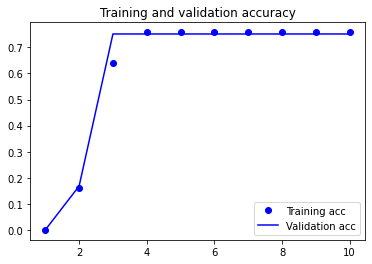

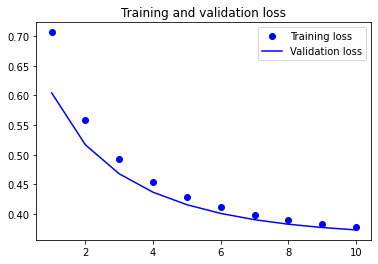

In [77]:
#Visualisation des résultats de l'entraînement.
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Test du modèle sur les données Trial

In [51]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/Fr_data/fr.trial.complete.json", "r") as file_handler:
    dataset_test = json.load(file_handler)

In [52]:
glosses_test = []
for e in dataset_test :
    glosses_test.append(e["gloss"])

In [53]:
sgns_test = []
for e in dataset_test :
    sgns_test.append(e["sgns"])

In [54]:
scores = model.evaluate(glosses_test, sgns_test, verbose=2)

7/7 - 1s - loss: 2.2538 - accuracy: 0.0250 - 578ms/epoch - 83ms/step


In [55]:
classes = model.predict(glosses_test, batch_size=32)

In [56]:
import torch.nn.functional as F
import torch

classes_tensor = torch.tensor(classes)
sgns_test_tensor = torch.tensor(sgns_test)

### Calcule des métriques d'évaluation

In [57]:
cos_sim = F.cosine_similarity(classes_tensor, sgns_test_tensor).mean().item()

In [58]:
print(cos_sim)

-0.0018758767982944846


In [59]:
mse = F.mse_loss(classes_tensor, sgns_test_tensor).item()

In [60]:
print(mse)

2.2537736892700195


In [61]:
# fonction prise du code de la baseline.
def rank_cosine(preds, targets):
    unique_targets = targets.unique(dim=0)
    all_assocs = preds @ F.normalize(targets).T
    unique_assocs = preds @ F.normalize(unique_targets).T
    refs = torch.diagonal(all_assocs, 0).unsqueeze(1)
    ranks = (unique_assocs >= refs).sum(1).float().mean().item()
    return ranks / unique_targets.size(0)

In [62]:
rnk = rank_cosine(classes_tensor, sgns_test_tensor)

In [63]:
print(rnk)

0.5046733683677175
